# Modello di deep learning per predizione dropout scolastico su dati INVALSI
Progetto del corso di **Intelligenza Artificiale**, A.A. 2020/2021

**LM Informatica**, **Alma Mater Studiorum - Università di Bologna**

Realizzato da:
- Marco Ferrati, matr. 983546
- Michele Perlino, matr. 983733
- Tommaso Azzalin, matr. 985911

Per aprire il notebook corrente sulla piattaforma Google Colab cliccare su [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MickPerl/MachineLearningProject/blob/main/AzzalinFerratiPerlino-INVALSI.ipynb)

# Setup dell'ambiente

## Installazione delle librerie necessarie

In [47]:
!pip3 install --no-cache-dir -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Import delle librerie fondamentali per l'analisi dei dati

In [48]:
import re
from beautifultable import BeautifulTable

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import IntegerLookup
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.callbacks import EarlyStopping

Com'è ben noto, il machine learning è un ambito in cui la sperimentazione occupa un ruolo molto importante: una volta consolidati i fondamenti teorici, abbiamo dovuto sperimentare innumerevoli architetture neurali differenti, tracciando di volta in volta le performance raggiunte.\
Al fine di rendere il codice del notebook quanto più flessibile, abbiamo creato lo script python `config.py` contenente la definizione degli iperparametri della rete; in dettaglio, in questo script, per ogni iperparametro, si verifica l'esistenza di una variabile d'ambiente col medesimo nome: in caso positivo, si assegna il valore di quest'ultima, mentre, in caso negativo, si assegna un valore di default.

`LEARNING_RATE = float(getenv(key="LEARNING_RATE", default="0.001"))`

Per settare variabili d'ambiente in maniera batch, abbiamo creato dei file con estensione `.env`:
- se si opera da PowerShell, è sufficiente dare il comando `Set-PsEnv` per definire tutte le variabili d'ambiente presenti nel file `env` che si trova nella directory corrente;
- se si opera da una shell Unix, si può impostare una variabile d'ambiente alla volta con `export nome_variabile=valore`: il contenuto di una variabile può essere controllato con `echo $nome_variabile`.

In [49]:
import src.config as cfg

All'interno della directory `src`, abbiamo creato altri due script python (`mapping_domande_ambiti_processi.py` e `column_converters`) contenente del codice che si è voluto separare da quello del notebook, per questioni di ordine e leggibilità. 

In [50]:
from src.mapping_domande_ambiti_processi import MAPPING_DOMANDE_AMBITI_PROCESSI
from src.column_converters import COLUMN_CONVERTERS

## Import del dataset originale

In [51]:
"""
Eseguire per: analisi dataset
"""
original_dataset = pd.read_csv(cfg.ORIGINAL_DATASET, sep=';', converters=COLUMN_CONVERTERS)

# EDA del dataset originale
Il codice che segue realizza il processo EDA, acronimo che sta per *exploratory data analysis*, al fine di scandagliare i punti di attenzione del dataset a disposizione.

In [52]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342226 entries, 0 to 342225
Columns: 104 entries, Unnamed: 0 to DROPOUT
dtypes: bool(52), float64(16), int64(11), object(25)
memory usage: 152.7+ MB


Come restituito dalla funzione `info()`, il dataset presenta $342226$ righe e $104$ colonne.

In [53]:
original_dataset.columns

Index(['Unnamed: 0', 'CODICE_SCUOLA', 'CODICE_PLESSO', 'CODICE_CLASSE',
       'macrotipologia', 'campione', 'livello', 'prog', 'CODICE_STUDENTE',
       'sesso',
       ...
       'PesoScuola', 'PesoTotale_Matematica', 'WLE_MAT', 'WLE_MAT_200',
       'WLE_MAT_200_CORR', 'pu_ma_no_corr', 'n_stud_prev', 'n_classi_prev',
       'LIVELLI', 'DROPOUT'],
      dtype='object', length=104)

Il dataset contiene svariate informazioni relative a studenti che hanno ultimato il ciclo di studi delle superiori: l'obiettivo del progetto è la progettazione e implementazione di un classificatore capace di predire, sulla base dei risultati conseguiti al test INVALSI di terza media, quali studenti registreranno un *dropout*.\
Il concetto di *dropout* può essere declinato su due livelli:
- **implicito**: si dice che lo studente ha registrato un dropout implicito nel caso in cui non abbia acquisito le minime conoscenze e competenze, per cui presenta lacune formative;
- **esplicito**: si dice che lo studente ha registrato un dropout esplicito nel caso in cui non abbia conseguito il diploma.

## Ricerca di colonne con alte percentuali di valori nulli

In [54]:
print("Columns with high null values percentages:")

table = BeautifulTable()
table.columns.header = ["", "Type","Ratio null values"]

for col in original_dataset.columns :
    ratio_null_values = original_dataset[col].isnull().mean().round(3)
    if ratio_null_values > 0:
        table.rows.append([col, str(original_dataset[col].dtypes), ratio_null_values]) 
        
table.columns.alignment = BeautifulTable.ALIGN_LEFT
table.set_style(BeautifulTable.STYLE_SEPARATED)
table.rows.sort('Ratio null values')
print(table)

Columns with high null values percentages:
+=======================+=========+===================+
|                       | Type    | Ratio null values |
+=======================+=========+===================+
| voto_orale_ita        | float64 | 0.113             |
+-----------------------+---------+-------------------+
| voto_orale_mat        | float64 | 0.114             |
+-----------------------+---------+-------------------+
| voto_scritto_ita      | float64 | 0.683             |
+-----------------------+---------+-------------------+
| voto_scritto_mat      | float64 | 0.683             |
+-----------------------+---------+-------------------+
| PesoClasse            | float64 | 0.946             |
+-----------------------+---------+-------------------+
| PesoScuola            | float64 | 0.946             |
+-----------------------+---------+-------------------+
| PesoTotale_Matematica | float64 | 0.946             |
+-----------------------+---------+-------------------+
| cod

In [55]:
columns_high_ratio_null_values = ["codice_orario", "PesoClasse", "PesoScuola", "PesoTotale_Matematica"]
columns_lower_ratio_null_values = [
    "voto_scritto_ita",  # 0.683
    "voto_scritto_mat",  # 0.113
    "voto_orale_ita",  # 0.683
    "voto_orale_mat"  # 0.114
]

## Ricerca colonne con un numero basso di valori distinti 

In [56]:
print("Columns with unique values:")

table = BeautifulTable()
table.columns.header = ["", "Ratio distinct values"]

for col in original_dataset.columns:
    ratio_unique_vals = round(original_dataset[col].nunique() / len(original_dataset), 3)
    if ratio_unique_vals  > 0.1 :
        table.rows.append([col, ratio_unique_vals]) 

table.columns.alignment = BeautifulTable.ALIGN_LEFT
table.set_style(BeautifulTable.STYLE_SEPARATED)
table.rows.sort('Ratio distinct values')
print(table)

Columns with unique values:
+==================+=======================+
|                  | Ratio distinct values |
+==================+=======================+
| WLE_MAT_200_CORR | 0.464                 |
+------------------+-----------------------+
| pu_ma_no_corr    | 0.494                 |
+------------------+-----------------------+
| Unnamed: 0       | 1.0                   |
+------------------+-----------------------+
| CODICE_STUDENTE  | 1.0                   |
+------------------+-----------------------+


Come era prevedibile, `Unnamed: 0` e `CODICE_STUDENTE` presentano una proporzione di valori distinti sul totale delle righe pari a 1, in quanto trattasi di indici/codici che identificano univocamente gli studenti. Queste due colonne potranno essere eliminate, dato che non portano alcuna informazione che possa aiutare a ravvisare relazioni tra gli studenti.

In [57]:
columns_with_unique_values = ["Unnamed: 0", "CODICE_STUDENTE"]

## Ricerca colonne con un singolo valore

In [58]:
print("Columns with just one value:")
for col in original_dataset.columns:
    unique_vals = original_dataset[col].nunique()
    if unique_vals == 1:
        print(col)

Columns with just one value:
macrotipologia
livello


Similmente, queste colonne possono essere eliminate in quanto non distinguono in alcuna maniera gli studenti.

In [59]:
columns_with_just_one_value = ["macrotipologia", "livello"]

## Rimozione delle colonne superflue

In [60]:
"""
Eseguire per: analisi dataset
"""
cleaned_original_dataset: pd.DataFrame = original_dataset.drop(
    columns_high_ratio_null_values + 
    columns_with_unique_values + 
    columns_with_just_one_value, 
    axis=1
)
cleaned_original_dataset.to_csv(cfg.CLEANED_DATASET)

In [61]:
"""
Eseguire per: analisi dataset
Attenzione: inutile eseguire se si è eseguita la precedente cella.
"""
cleaned_original_dataset = pd.read_csv(cfg.CLEANED_DATASET)

C:\Users\miche\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [62]:
if "Unnamed: 0" in cleaned_original_dataset.columns:
    cleaned_original_dataset.drop("Unnamed: 0", axis=1, inplace=True)

## Generalizzazione dataset per supportare altre coorti di studenti
Addestrando la rete con le domande specifiche di un certo test INVALSI non si ottiene un classificatore riutilizzabile per coorti successive. Pertanto, abbiamo pensato di mappare le feature inerenti alle domande in uno spazio più generico che permetta di cogliere la semantica delle domande piuttosto che la loro rappresentazione letterale; mediante le griglie di correzione fornite ai docenti, abbiamo notato che ogni domanda è caratterizzato da uno o più ambiti e processi: questa corrispondenza ha ispirato la trasformazione dello spazio di rappresentazione delle domande che riportiamo di seguito. 

Nel file `mapping_domande_ambiti_processi` posizionato nella cartella `src` abbiamo creato un dizionario le cui chiavi sono le domande e i valori gli ambiti e i processi corrispondenti. Dopo averlo importato nel notebook corrente, abbiamo estratto i distinti ambiti e processi per poi calcolarne il numero di domande che caratterizzano.

In [63]:
list_ambiti_processi = [AP for val in MAPPING_DOMANDE_AMBITI_PROCESSI.values() for AP in val]
ambiti_processi = set(list_ambiti_processi)
conteggio_ambiti_processi = {AP: list_ambiti_processi.count(AP) for AP in ambiti_processi}   

Abbiamo proceduto con l'aggiungere al dataset originale colonne recanti il nome degli ambiti e processi, inizializzate a 0 per tutte le righe.

In [64]:
"""
Eseguire per: analisi dataset
"""
dataset_with_ambiti_processi = cleaned_original_dataset.copy()
for AP in ambiti_processi:
    dataset_with_ambiti_processi[AP] = 0.0

Col codice seguente, ogni studente sarà caratterizzato da un valore per ogni ambito e processo corrispondente alla proporzione di domande che vi si riferivano e a cui ha risposto correttamente: ad esempio, nel caso un processo `x` vada a caratterizzare 10 domande e lo studente risponda correttamente a 5 di queste ultime, allora il valore che quello studente presenterà sotto il processo `x` sarà pari a $0.5$.

In [65]:
"""
Eseguire per: rimozione feature sulle domande e aggiunta feature sugli ambiti e processi
"""
questions_columns = [col for col in list(cleaned_original_dataset) if re.search("^D\d", col)]

for i, row in dataset_with_ambiti_processi.iterrows():
    for question, APs in MAPPING_DOMANDE_AMBITI_PROCESSI.items():
        if row[question] == True:   # se ha risposto correttamente
            for AP in APs:
                dataset_with_ambiti_processi.at[i, AP] += 1 / conteggio_ambiti_processi[AP]

dataset_ap = dataset_with_ambiti_processi.drop(questions_columns, axis=1)

dataset_ap.to_csv(cfg.CLEANED_DATASET_WITH_AP)

In [66]:
"""
Eseguire per: rimozione feature sulle domande e aggiunta feature sugli ambiti e processi
Attenzione: inutile eseguire se si è eseguita la precedente cella.
"""
dataset_ap = pd.read_csv(cfg.CLEANED_DATASET_WITH_AP)

In [67]:
if "Unnamed: 0" in dataset_ap.columns:
    dataset_ap.drop("Unnamed: 0", axis=1, inplace=True)

## Analisi della correlazione fra feature

In [68]:
corr_matrix = dataset_ap.corr(method='pearson').round(2)
corr_matrix.style.background_gradient(cmap='YlOrRd')

,CODICE_SCUOLA,CODICE_PLESSO,CODICE_CLASSE,campione,prog,voto_scritto_ita,voto_orale_ita,voto_scritto_mat,voto_orale_mat,Pon,pu_ma_gr,pu_ma_no,Fattore_correzione_new,Cheating,WLE_MAT,WLE_MAT_200,WLE_MAT_200_CORR,pu_ma_no_corr,n_stud_prev,n_classi_prev,LIVELLI,DROPOUT,"Utilizzare strumenti, modelli e rappresentazioni nel trattamento quantitativo dell'informazione in ambito scientifico, tecnologico, economico e sociale","Rappresentare relazioni e dati e, in situazioni significative, utilizzare le rappresentazioni per ricavare informazioni, formulare giudizi e prendere decisioni",Relazioni e funzioni,Acquisire progressivamente forme tipiche del pensiero matematico,Riconoscere le forme nello spazio e utilizzarle per la risoluzione di problemi geometrici o di modellizzazione,"Risolvere problemi utilizzando strategie in ambiti diversi – numerico, geometrico, algebrico –",Dati e previsioni,Numeri,"Riconoscere in contesti diversi il carattere misurabile di oggetti e fenomeni, utilizzare strumenti di misura, misurare grandezze, stimare misure di grandezze",Spazio figure,Conoscere e padroneggiare i contenuti specifici della matematica,Conoscere e utilizzare algoritmi e procedure
CODICE_SCUOLA,1.000000,-0.010000,1.000000,0.000000,-0.050000,-0.020000,-0.030000,-0.020000,-0.020000,-0.080000,-0.030000,-0.030000,0.040000,-0.040000,-0.010000,-0.030000,-0.000000,-0.010000,-0.160000,-0.380000,-0.030000,0.020000,-0.030000,-0.010000,-0.020000,-0.020000,-0.020000,-0.030000,-0.030000,-0.030000,-0.020000,-0.020000,-0.020000,-0.020000
CODICE_PLESSO,-0.010000,1.000000,-0.010000,-0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,-0.020000,0.010000,0.010000,-0.010000,0.010000,0.000000,0.010000,0.010000,0.010000,0.020000,0.010000,0.010000,-0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
CODICE_CLASSE,1.000000,-0.010000,1.000000,0.000000,-0.050000,-0.020000,-0.030000,-0.020000,-0.020000,-0.080000,-0.030000,-0.030000,0.040000,-0.040000,-0.010000,-0.030000,-0.000000,-0.010000,-0.160000,-0.380000,-0.030000,0.020000,-0.030000,-0.010000,-0.020000,-0.020000,-0.020000,-0.030000,-0.030000,-0.030000,-0.020000,-0.020000,-0.020000,-0.020000
campione,0.000000,-0.010000,0.000000,1.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.010000,-0.040000,-0.020000,-0.020000,-0.010000,0.010000,-0.010000,-0.020000,0.040000,-0.020000,0.010000,-0.020000,-0.000000,0.000000,-0.010000,-0.000000,-0.010000,-0.010000,-0.010000,-0.020000,-0.010000,-0.020000,-0.010000,-0.010000,-0.010000,-0.020000
prog,-0.050000,0.010000,-0.050000,0.000000,1.000000,0.020000,0.020000,0.010000,0.020000,-0.000000,0.020000,0.020000,0.000000,-0.000000,0.010000,0.020000,0.020000,0.020000,0.280000,0.060000,0.020000,-0.020000,0.020000,0.000000,0.010000,0.010000,0.010000,0.020000,0.020000,0.020000,0.010000,0.020000,0.020000,0.020000
voto_scritto_ita,-0.020000,0.000000,-0.020000,-0.000000,0.020000,1.000000,0.870000,0.750000,0.660000,-0.030000,0.430000,0.430000,-0.040000,0.040000,0.060000,0.440000,0.380000,0.400000,0.050000,-0.010000,0.370000,-0.310000,0.340000,0.150000,0.340000,0.300000,0.220000,0.260000,0.340000,0.360000,0.270000,0.340000,0.290000,0.360000
voto_orale_ita,-0.030000,0.010000,-0.030000,-0.000000,0.020000,0.870000,1.000000,0.650000,0.720000,-0.030000,0.450000,0.450000,-0.020000,0.020000,0.070000,0.450000,0.410000,0.430000,0.060000,-0.000000,0.400000,-0.340000,0.350000,0.160000,0.360000,0.320000,0.230000,0.280000,0.350000,0.370000,0.280000,0.360000,0.300000,0.370000
voto_scritto_mat,-0.020000,0.000000,-0.020000,-0.000000,0.010000,0.750000,0.650000,1.000000,0.880000,-0.050000,0.520000,0.520000,-0.040000,0.040000,0.070000,0.530000,0.470000,0.490000,0.030000,-0.020000,0.480000,-0.390000,0.390000,0.190000,0.410000,0.360000,0.270000,0.340000,0.400000,0.440000,0.330000,0.420000,0.360000,0.430000
voto_orale_mat,-0.020000,0.010000,-0.020000,-0.010000,0.020000,0.660000,0.720000,0.880000,1.000000,-0.050000,0.550000,0.550000,-0.010000,0.0100

Emerge un'alta correlazione ($0.87$) tra i voti della stessa materia, come era prevedibile, mentre una correlazione abbastanza alta tra materie differenti ($0.75$). La correlazione pari a $1$ tra `pu_ma_gr` e `pu_ma_no` si spiega considerando che la seconda è la normalizzazione della prima, per cui portano esattamente la stessa informazione.

Abbiamo ritenuto interessante indagare la correlazione sussistente tra i voti agli scritti e agli orali, i punteggi finali ottenuti al test e gli ambiti e i processi: abbiamo previsto solo valori positivi di correlazione, in quanto a voti maggiori, corrispondono punteggi finali maggiori, come anche per i processi e ambiti. 

In [69]:
interesting_to_check_if_correlated_columns = [
    # Alta correlazione fra voti della stessa materia, abbastanza correlate fra materie diverse
    "voto_scritto_ita",
    "voto_orale_ita",
    "voto_scritto_mat",
    "voto_orale_mat",
    # Correlazione totale, abbastanza correlate con voti
    "pu_ma_no"
] + list(ambiti_processi)

In [70]:
check_corr_dataset = dataset_ap[interesting_to_check_if_correlated_columns].corr(method='pearson').round(2)
check_corr_dataset.style.background_gradient(cmap='YlOrRd')

,voto_scritto_ita,voto_orale_ita,voto_scritto_mat,voto_orale_mat,pu_ma_no,"Utilizzare strumenti, modelli e rappresentazioni nel trattamento quantitativo dell'informazione in ambito scientifico, tecnologico, economico e sociale","Rappresentare relazioni e dati e, in situazioni significative, utilizzare le rappresentazioni per ricavare informazioni, formulare giudizi e prendere decisioni",Relazioni e funzioni,Acquisire progressivamente forme tipiche del pensiero matematico,Riconoscere le forme nello spazio e utilizzarle per la risoluzione di problemi geometrici o di modellizzazione,"Risolvere problemi utilizzando strategie in ambiti diversi – numerico, geometrico, algebrico –",Dati e previsioni,Numeri,"Riconoscere in contesti diversi il carattere misurabile di oggetti e fenomeni, utilizzare strumenti di misura, misurare grandezze, stimare misure di grandezze",Spazio figure,Conoscere e padroneggiare i contenuti specifici della matematica,Conoscere e utilizzare algoritmi e procedure
voto_scritto_ita,1.000000,0.870000,0.750000,0.660000,0.430000,0.340000,0.150000,0.340000,0.300000,0.220000,0.260000,0.340000,0.360000,0.270000,0.340000,0.290000,0.360000
voto_orale_ita,0.870000,1.000000,0.650000,0.720000,0.450000,0.350000,0.160000,0.360000,0.320000,0.230000,0.280000,0.350000,0.370000,0.280000,0.360000,0.300000,0.370000
voto_scritto_mat,0.750000,0.650000,1.000000,0.880000,0.520000,0.390000,0.190000,0.410000,0.360000,0.270000,0.340000,0.400000,0.440000,0.330000,0.420000,0.360000,0.430000
voto_orale_mat,0.660000,0.720000,0.880000,1.000000,0.550000,0.420000,0.200000,0.440000,0.380000,0.290000,0.360000,0.420000,0.460000,0.340000,0.440000,0.380000,0.450000
pu_ma_no,0.430000,0.450000,0.520000,0.550000,1.000000,0.760000,0.420000,0.800000,0.660000,0.570000,0.670000,0.760000,0.830000,0.620000,0.800000,0.680000,0.770000
"Utilizzare strumenti, modelli e rappresentazioni nel trattamento quantitativo dell'informazione in ambito scientifico, tecnologico, economico e sociale",0.340000,0.350000,0.390000,0.420000,0.760000,1.000000,0.260000,0.630000,0.410000,0.320000,0.440000,0.870000,0.520000,0.390000,0.510000,0.420000,0.540000
"Rappresentare relazioni e dati e, in situazioni significative, utilizzare le rappresentazioni per ricavare informazioni, formulare giudizi e prendere decisioni",0.150000,0.160000,0.190000,0.200000,0.420000,0.260000,1.000000,0.590000,0.210000,0.170000,0.230000,0.260000,0.260000,0.200000,0.250000,0.200000,0.260000
Relazioni e funzioni,0.340000,0.360000,0.410000,0.440000,0.800000,0.630000,0.590000,1.000000,0.740000,0.330000,0.450000,0.520000,0.540000,0.410000,0.520000,0.490000,0.550000
Acquisire progressivamente forme tipiche del pensiero matematico,0.300000,0.320000,0.360000,0.380000,0.660000,0.410000,0.210000,0.740000,1.000000,0.270000,0.360000,0.400000,0.490000,0.340000,0.470000,0.370000,0.420000
Riconoscere le forme nello spazio e utilizzarle per la risoluzione di problemi geometrici o di modellizzazione,0.220000,0.230000,0.270000,0.290000,0.570000,0.320000,0.170000,0.330000,0.270000,1.000000,0.300000,0.330000,0.340000,0.290000,0.780000,0.260000,0.340000


La nostra previsione è stata confermata.

### Rimozione colonne altamente correlate

In [71]:
# TODO Rimozione colonne altamente correlate

## Analisi dei tipi delle colonne

In [72]:
print("Lista colonne e tipi:")

table = BeautifulTable()
table.columns.header = ["", "Type"]

for col in dataset_ap.columns :
    table.rows.append([col, dataset_ap[col].dtypes])
        
table.columns.alignment = BeautifulTable.ALIGN_LEFT
table.set_style(BeautifulTable.STYLE_SEPARATED)
print(table)

Lista colonne e tipi:
+====================================================================+=========+
|                                                                    | Type    |
+====================================================================+=========+
| CODICE_SCUOLA                                                      | int64   |
+--------------------------------------------------------------------+---------+
| CODICE_PLESSO                                                      | int64   |
+--------------------------------------------------------------------+---------+
| CODICE_CLASSE                                                      | int64   |
+--------------------------------------------------------------------+---------+
| campione                                                           | int64   |
+--------------------------------------------------------------------+---------+
| prog                                                               | int64   |
+-----

In [73]:
continuous_features = columns_lower_ratio_null_values + \
                      ["pu_ma_gr", "pu_ma_no", "Fattore_correzione_new", "Cheating", "WLE_MAT", "WLE_MAT_200", "WLE_MAT_200_CORR",
                       "pu_ma_no_corr"] + \
                      list(ambiti_processi) # Feature sui voti, feature elencate, ambiti e processi
ordinal_features = [
    "n_stud_prev", "n_classi_prev", "LIVELLI", "voto_scritto_mat", "voto_orale_mat"
] + (["voto_scritto_ita", "voto_orale_ita"] if cfg.FILL_NAN != "remove" else []) # se si rimuovono le colonne dei voti di italiano non vanno messe tra le feature
int_categorical_features = [
    "CODICE_SCUOLA", "CODICE_PLESSO", "CODICE_CLASSE", "campione", "prog",
]
str_categorical_features = [
    "sesso", "mese", "anno", "luogo", "eta", "freq_asilo_nido", "freq_scuola_materna",
    "luogo_padre", "titolo_padre", "prof_padre", "luogo_madre", "titolo_madre", "prof_madre",
    "regolarità", "cittadinanza", "cod_provincia_ISTAT", "Nome_reg",
    "Cod_reg", "Areageo_3", "Areageo_4", "Areageo_5", "Areageo_5_Istat"
]
bool_features = ["Pon"]

## Gestione dei valori nulli
Il dataset in considerazione presenta molti valori nulli.\
Vi sono diverse tecniche per gestirli, tra cui:
- sostituzione del valore nullo con un indice di sintesi (media, mediana, moda) della colonna in considerazione: la scelta dell'indice dipende da vari fattori, tra cui la forma della distribuzione del certo attributo;
- rimozione della riga corrispondente: viene adottata solitamente quando la colonna presenta pochi valori nulli e/o la riga presenta molti valori nulli;
- rimozione della colonna corrispondente: viene adottata solitamente quando la colonna presenta un alto numero di valori nulli.

In [76]:
dataset_ap["sigla_provincia_istat"].fillna(value="ND", inplace=True)
# TODO Trovare un modo migliore per effettuare il rimpiazzo dei non disponibili.
dataset_ap["sigla_provincia_istat"].fillna(value="ND", inplace=True)

if cfg.FILL_NAN == "remove":
    # Rimuovere colonne voti ita
    # Rimuovere record con dati nulli in voti mat
    dataset_ap.drop(["voto_scritto_ita", "voto_orale_ita"], axis=1, inplace=True)
    dataset_ap.dropna(["voto_scritto_mat", "voto_orale_mat"], inplace=True)
else :
    for col in columns_lower_ratio_null_values : 
        if cfg.FILL_NAN == "median":
            replaced_value = dataset_ap[col].median()
        elif cfg.FILL_NAN == "mean":
            replaced_value = dataset_ap[col].mean()
        elif cfg.FILL_NAN == "mode":
            replaced_value = dataset_ap[col].mode()

        dataset_ap[col].fillna(value=replaced_value, inplace=True)   

# Machine Learning
## Suddivisione dataset in training e test
Avendo un dataset di una sola coorte di studenti relativi alle prove di un anno, non si dispone di un set per fare testing: Idealmente, l'insieme di testing dovrebbe referirsi ad una coorte diversa da quella su cui è stato effettuato il training. Nel caso di specie, tuttavia, si dispone dei dati relativi ad un'unica coorte, per cui abbiamo pensato di eseguire lo split in questo modo:

1. dataset diviso in train_dataset (default 80%) e test_dataset (default 20%);
2. train_dataset diviso in train_dataset (default 80%) e validation_dataset (default 20%).

In [29]:
df_training_set, df_test_set = train_test_split(dataset_ap, test_size=cfg.TEST_SET_PERCENT)

## Analisi dello sbilanciamento del dataset

In [30]:
nr_nodrop, nr_drop = np.bincount(dataset_ap['DROPOUT'])
total_records = nr_drop + nr_nodrop
nl = '\n'
print(
    f"Total number of records: {total_records}{nl}\
        {nl}\
Total num. DROPOUT: {nr_drop}{nl}\
Total num. NO DROPOUT: {nr_nodrop}{nl}\
    {nl}\
Ratio DROPOUT/TOTAL: {round(nr_drop / total_records, 2)}{nl}\
Ratio NO DROPOUT/TOTAL: {round(nr_nodrop / total_records, 2)}{nl}\
    {nl}\
Ratio DROPOUT/NO DROPOUT: {round(nr_drop / nr_nodrop, 2)}"
)

Total number of records: 342226
        
Total num. DROPOUT: 116782
Total num. NO DROPOUT: 225444
    
Ratio DROPOUT/TOTAL: 0.34
Ratio NO DROPOUT/TOTAL: 0.66
    
Ratio DROPOUT/NO DROPOUT: 0.52


Le due classi (i.e. target del classificatore) appaiono leggermente sbilanciate: in dettaglio, la classe dei soggetti che manifestano dropout ha una cardinalità inferiore della classe in cui non si è avuto dropout.

### Gestione dello sbilanciamento

Vi sono diverse tecniche per gestire lo sbilanciamento tra le classi di un attributo, tra cui:
- **ricampionamento dei dati**: 
    - *random over sampling*: selezionare randomicamente delle istanze della classe sotto rappresentata e duplicarle fino a quando le cardinalità delle classi si equivalgono; aumenta il rischio di overfitting;
    - *random under sampling*: rimuovere istanze della classe sovrarappresentata fintanto che le cardinalità delle classi si equivalgono; causa una riduzione del training set;
    - *cluster-based over-sampling*: esecuzione dell'algoritmo *k-means* indipendentemente sulle istanze della classe maggiormente rappresentata e su quelle della classe meno rappresentata per poi compiere oversampling sui cluster ottenuti fin tanto che le cardinalità dei cluster di una stessa classe si equivalgono come anche le cardinalità delle classi nel loro complesso;
- **generazione di dati sintetici**: 
    - *SMOTE* (Synthetic Minority Over-sampling Technique): selezionare due o più istanze simili della classe sotto rappresentata e modificare leggermente il valore di un attributo alla volta di un ammontare inferiore alla differenza tra le istanze simili; evita l'overfitting (a patto che vi siano poche attributi) ma aumenta il rumore;
- **cambiare la natura del problema**: da classificazione a *anomaly detection* o *change detection*;
- **penalizzazione delle classificazioni errate sulla classe sottorappresentata**: *Cost-sensitive Training*;
- **monitorare metriche diverse dall'accuratezza**, in quanto solitamente si ottengono ottimi valori di accuratezza con dati sbilanciati, perché il modello classifica tutti gli input come appartenenti alla classe più numerosa.

Alla luce di queste tecniche e considerate le peculiarità del nostro dataset emerse durante la EDA, abbiamo ritenuto che la tecnica migliore al caso nostro fosse il *random over sampling*: il nostro dataset presenta un alto numero di istanze e le classi dell'attributo target presentano un sbilanciamento poco accentuato per cui conviene ricorrere ad un sottocampionamento randomico, evitando così il rischio di overfitting, piuttosto che al sovracampionamento.




In [31]:
"""
Eseguire per: campionamento
"""
if cfg.SAMPLING_TO_PERFORM == "random_undersampling":
    # class_nodrop contiene i record della classe sovrarappresentata, ovvero SENZA DROPOUT.
    class_nodrop = df_training_set[df_training_set['DROPOUT'] == False]
    # class_drop contiene i record della classe sottorappresentata, ovvero CON DROPOUT.
    class_drop = df_training_set[df_training_set['DROPOUT'] == True]

    # Sotto campionamento di class_drop in modo che abbia stessa cardinalità di class_nodrop
    class_nodrop = class_nodrop.sample(len(class_drop))

    print(f'Class NO DROPOUT: {len(class_nodrop):,}')
    print(f'Classe DROPOUT: {len(class_drop):,}')

    df_training_set = class_drop.append(class_nodrop)
    df_training_set = df_training_set.sample(frac=1)
elif cfg.SAMPLING_TO_PERFORM == "SMOTE":
    print("SMOTE not yet implemented")
else:
    print(f"SAMPLING_TO_PERFORM = {cfg.SAMPLING_TO_PERFORM} not recognized.")

Class NO DROPOUT: 93,486
Classe DROPOUT: 93,486


Ecco che il training set è stato bilanciato.

In [32]:
if "Unnamed: 0" in df_training_set.columns:
    df_training_set.drop("Unnamed: 0", axis=1, inplace=True)

## Preprocessing per creazione del modello di Deep Learning

### Suddivisione del dataset in training e validation

In [33]:
df_training_set, df_validation_set = train_test_split(df_training_set, test_size=cfg.VALIDATION_SET_PERCENT)

### Conversione dei dati da DataFrame (Pandas) a Dataset (Tensorflow/Keras)

In [34]:
def pd_dataframe_to_tf_dataset(dataframe: pd.DataFrame):
    copied_df = dataframe.copy()
    dropout_col = copied_df.pop("DROPOUT")
    """
    Dato che il dataframe ha dati eterogenei lo convertiamo a dizionario,
    in cui le chiavi sono i nomi delle colonne e i valori sono i valori della colonna.
    Infine bisogna indicare la colonna target.
    """
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(copied_df), dropout_col))
    tf_dataset = tf_dataset.shuffle(buffer_size=len(copied_df))
    return tf_dataset

In [35]:
ds_training_set = pd_dataframe_to_tf_dataset(df_training_set)
ds_validation_set = pd_dataframe_to_tf_dataset(df_validation_set)
ds_test_set = pd_dataframe_to_tf_dataset(df_test_set)

### Suddivisione del dataset in batch

In [36]:
ds_training_set = ds_training_set.batch(cfg.BATCH_SIZE, drop_remainder=True)
ds_validation_set = ds_validation_set.batch(cfg.BATCH_SIZE, drop_remainder=True)
ds_test_set = ds_test_set.batch(cfg.BATCH_SIZE, drop_remainder=True)

In [37]:
df_training_set.items()

<generator object DataFrame.items at 0x000002DD332A55F0>

### Creazione dei layer di input per ogni feature

In [38]:
input_layers = {}
for name, column in df_training_set.items():
    if name == "DROPOUT":
        continue

    if name in continuous_features:
        dtype = tf.float32
    elif name in ordinal_features or name in int_categorical_features or name in bool_features:
        dtype = tf.int64
    else:  # str_categorical_features
        dtype = tf.string

    input_layers[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

### Encoding delle feature in base al loro tipo

In [39]:
preprocessed_features = []

def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)

In [40]:
# Preprocessing colonne con dati booleani
for name in bool_features:
    inp = input_layers[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed_features.append(float_value)

In [41]:
# Preprocessing colonne con dati interi ordinali
ordinal_inputs = {}
for name in ordinal_features:
    ordinal_inputs[name] = input_layers[name]

normalizer = Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(df_training_set[ordinal_features])))
ordinal_inputs = stack_dict(ordinal_inputs)
ordinal_normalized = normalizer(ordinal_inputs)
preprocessed_features.append(ordinal_normalized)

In [42]:
# Preprocessing colonne con dati continui
continuous_inputs = {}
for name in continuous_features:
    continuous_inputs[name] = input_layers[name]

normalizer = Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(df_training_set[continuous_features])))
continuous_inputs = stack_dict(continuous_inputs)
continuous_normalized = normalizer(continuous_inputs)
preprocessed_features.append(continuous_normalized)

In [43]:
# Preprocessing colonne con dati categorici stringa
for name in str_categorical_features:
    vocab = sorted(set(df_training_set[name]))

    lookup = StringLookup(vocabulary=vocab, output_mode='one_hot')

    x = input_layers[name][:, tf.newaxis]
    x = lookup(x)

    preprocessed_features.append(x)

In [44]:
# Preprocessing colonne con dati categorici interi
for name in int_categorical_features:
    vocab = sorted(set(df_training_set[name]))

    lookup = IntegerLookup(vocabulary=vocab, output_mode='one_hot')

    x = input_layers[name][:, tf.newaxis]
    x = lookup(x)

    preprocessed_features.append(x)

### Assemblaggio dei vari layer e creazione del modello
Abbiamo pensato di sperimentare anche la funzione di attivazione Leaky ReLu.\
![](./src/img/leaky_relu.png)

Da leggere con calma https://himanshuxd.medium.com/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

In [45]:
# initializer = tf.keras.initializers.glorot_uniform(seed=19)

preprocessed = tf.concat(preprocessed_features, axis=-1)

preprocessor = tf.keras.Model(input_layers, preprocessed)

"""
body = tf.keras.Sequential(
    [tf.keras.layers.Dense(cfg.NEURONS, activation=cfg.DENSE_LAYER_ACTIVATION) for _ in range(cfg.NUMBER_OF_LAYERS)] +
    [tf.keras.layers.Dropout(cfg.DROPOUT_LAYER_RATE)] if cfg.DROPOUT_LAYER else [] +
    [tf.keras.layers.Dense(1, activation=cfg.OUTPUT_ACTIVATION_FUNCTION)]
)
"""
body = tf.keras.Sequential()
for _ in range(cfg.NUMBER_OF_LAYERS):
    if cfg.LEAKY_RELU:
        body.add(tf.keras.layers.Dense(cfg.NEURONS))
        body.add(tf.keras.layers.LeakyReLU())
    else:
        body.add(tf.keras.layers.Dense(cfg.NEURONS, activation=cfg.DENSE_LAYER_ACTIVATION))
if cfg.DROPOUT_LAYER:
    body.add(tf.keras.layers.Dropout(cfg.DROPOUT_LAYER_RATE))
body.add(tf.keras.layers.Dense(1, activation=cfg.OUTPUT_ACTIVATION_FUNCTION))

x = preprocessor(input_layers)

result = body(x)

model = tf.keras.Model(input_layers, result)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Acquisire progressivamente form [(None,)]            0                                            
__________________________________________________________________________________________________
Areageo_3 (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
Areageo_4 (InputLayer)          [(None,)]            0                                            
__________________________________________________________________________________________________
Areageo_5 (InputLayer)          [(None,)]            0                                            
____________________________________________________________________________________________

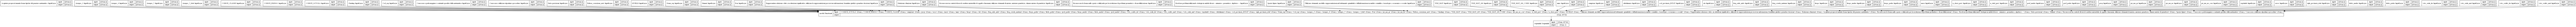

In [46]:
# Visualizzazione tabellare del modello
from keras.utils.vis_utils import plot_model
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

### Compilazione del modello e scelta delle metriche

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
              loss=tf.losses.BinaryCrossentropy(),
              metrics=[
                  tf.metrics.Accuracy(),
                  tf.metrics.BinaryAccuracy(),
                  tf.metrics.Precision(),
                  tf.metrics.Recall(),
                  tf.metrics.FalseNegatives(),
                  tf.metrics.FalsePositives(),
                  tf.metrics.TrueNegatives(),
                  tf.metrics.TruePositives()])

### Early stopping

In [ ]:
"""
Definizione dello stopper per evitare che la reti continui ad addestrarsi quando non ci sono miglioramenti della loss 
(val_loss = funzione di costo sul validation set) per piu' di 3 epoche
"""
early_stopper = EarlyStopping(monitor="val_loss", patience=2)

### Training

In [ ]:
model.fit(ds_training_set,
          epochs=cfg.EPOCH,
          batch_size=cfg.BATCH_SIZE,
          validation_data=ds_validation_set,
          callbacks=[early_stopper],
          verbose=2)

### Test

In [ ]:
score = model.evaluate(ds_test_set)

## Risultati ottenuti


| Epoche | Neuroni | Batch | Tecnica di sampling | Layer lineari | Tasso apprendimento | Dropout | Tasso di dropout | Accuratezza in training | Accuratezza in test | Note aggiuntive |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|     10 |     128 |    32 |       Undersampling |            10 |               0.001 |      No |                - |                  0.2339 |              0.2336 | C'erano colonne con alta correlazione. |
|     50 |     128 |    32 |       Undersampling |            10 |               0.001 |      No |                - |                  0.6938 |              0.6874 | C'erano colonne con alta correlazione. |
|     50 |     256 |    32 |       Undersampling |            10 |               0.001 |      No |                - |                  0.6944 |              0.6873 | C'erano colonne con alta correlazione. |
|     50 |     128 |   128 |       Undersampling |            10 |               0.001 |      No |                - |                  0.2386 |              0.2341 | C'erano colonne con alta correlazione. Perché è così pessimo il risultato? |

Per info su come formattare Markdown: [clicca qui](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd).

# Esecuzione su Cluster HPC
Per via della numerosità e complessità computazionale dei test nella fase di progettazione dell'architettura della rete, abbiamo pensato di usufruire del servizio di High Performance Computing su cluster dipartimentale con GPU offerto dal dipartimento DISI.

Dopo aver fatto richiesta, i nostri account istituzionali sono stati abilitati all'accesso ai sistemi dipartimentali e al cluster stesso: la macchina di nostro interesse è `slurm.cs.unibo.it` su cui si trova lo schedulatore del cluster. 

In dettaglio, il cluster utilizza uno schedulatore [SLURM](https://slurm.schedmd.com/overview.html) per la distribuzione 
dei job. Pertanto, per effettuare il submit di un job, abbiamo predisposto nella nostra area di lavoro un file di script 
SLURM contenente le direttive per la configurazione del job di interesse.\
Sulla scia delle [raccomandazioni](https://disi.unibo.it/it/dipartimento/servizi-tecnici-e-amministrativi/servizi-informatici/utilizzo-cluster-hpc/unibo.tiles.multi.links_attachments/e7809f6f52644346a912b99dd2280788/@@objects-download/11906a7e3d2345278c0fc5ee68ce7975/file/IstruzioniUsoClusterGPU.pdf) contenute nelle istruzioni consegnateci dai tecnici del DISI, abbiamo proceduto col creare sulla macchina slurm un virtual environment 
Python, in cui, mediante il comando `pip3 install` abbiamo installato le dipendenze necessarie (specificate nel file di testo `requirements.txt`).

Abbiamo creato differenti file di script SLURM per le diverse architetture neurali progettate. A titolo di esempio, riportiamo il contenuto dello script di default.

```bash
#!/bin/bash\
#SBATCH --job-name=default\
#SBATCH --mail-type=ALL\
#SBATCH --mail-user=tommaso.azzalin@studio.unibo.it\
#SBATCH --time=20:00:00\
#SBATCH --nodes=1\
#SBATCH --ntasks-per-node=1\
#SBATCH --output=default\
#SBATCH --gres=gpu:1\

cd  ../

. venv/bin/activate # per attivare il virtual environment python

pip3 install -r requirements.txt

python3 src/base.py
```

# Lavori futuri
Abbiamo intenzione di continuare a lavorare a questo progetto, perché riteniamo sia un ottimo banco di prova per maturare nuove conoscenze e competenze relative al Machine Learning. In dettaglio, prevediamo di concentrare gli sforzi futuro lungo le seguenti direzioni:
- gestione dello sbilanciamento del training set mediante:
    - *SMOTE*, in quanto permette di evitare la riduzione di cardinalità del training set che inevitabilmente segue al *random under-sampling*, senza rischiare l'overfitting proprio del *random over-sampling*;
    - *Random Weighted Sampling*.